In [25]:
import math
import numpy as np
import random

x_current=[]
v_current=[]

# Setup calls and functions

In [26]:
# this just makes my arrays longer if I need more data points
def extend_array(arr, n):
    extended_arr = arr.copy()
    for i in range(len(arr)):
        for j in range(n):
            if len(extended_arr) >= n:
                break
            extended_arr.append(arr[i])
        if len(extended_arr) >= n:
            break
    
    duplicated_values = extended_arr[len(arr):]
    random.shuffle(duplicated_values)
    extended_arr[len(arr):] = duplicated_values
    
    return extended_arr[:n]


In [27]:
def create_2d_array(arr):
    result = []
    for value in arr:
        result.append([value])
    return result

# Eulers Method Setup Functions
All functions take the form :
<center><h2>

$X''+B(t)X'+C(t)X=D(t)$

</center></h2>

Where each letter is a matrix, all X and D matricies are columns, and all else is a square matrix

In [28]:
def firstOrder(v_0,x_0,h):
    x_1=h*v_0+x_0
    return x_1
string_length = 10
def zerothOrderParam(x):
    return x
def firstOrderParam(v):
    return v 

In [29]:
def RK_weighting(v):
    v_weighted = 1/6*(v[0]+2*v[1]+2*v[2]+v[3])
    return v_weighted

In [30]:
def secondOrder(v_0,x_1,h,b,a,c,d,zerothOrderParam,firstOrderParam,constant=0,t=0):
    slope = (d(t)-b*firstOrderParam(v_0)-c*zerothOrderParam(x_1)-constant)/a
   
    v_1= h*slope+v_0
    return v_1

In [31]:
def calculateStep(x_0,v_0,iteration,h,a,b,c,d,zerothOrderParam,firstOrderParam,constant = 0,method = 'Euler'):
    # print all inputs

    time = h*iteration
    v_1 = secondOrder(v_0,x_0,h,b,a,c,d,zerothOrderParam,firstOrderParam,t=time,constant = constant)
    x_1 = firstOrder(v_1,x_0,h)
    return v_1,x_1

    # We want RK4 only to calculate the velocity for us, and then we can update velocities seperately
    
    # Calculate the next step
def euler(x_0,v_0,iterations,h,a,b,c,d,zerothOrderParam,firstOrderParam):
    x = []
    time = []
    for i in range(int(iterations/h)):
        t = h*i
        v_1 = secondOrder(v_0,x_0,h,b,a,c,d,zerothOrderParam,firstOrderParam,t=t)
        x_1 = firstOrder(v_1,x_0,h)
        # This term is recorded in this iteration
        # This term is used in the second iteration
        x_0 = x_1
        x.append(x_0)
        time.append(t)
        v_0 = v_1
    return x,time

# Coefficient Matrix
*Biggest Computation Sink*
The x matrix on the right, multiplied by the K matrix on the left. If we are on the ith object, we isolate the corresponding k value (italicised), and save that as the coefficient. Then we take the dot product of the remaining terms in the matricies to combine the other x terms. The left column matrix is recursivley defined on the previous iteration, while the square matrix is always constant
<h2><center>

$\begin{bmatrix}
\textbf{X}_1 \\ 
\vdots \\
x_i \\
\vdots \\
\textbf{X}_n
\end{bmatrix}
\begin{bmatrix}
\phantom{x} & \phantom{x} & \phantom{x} & \phantom{x} & \dots \\
\phantom{x} & \phantom{x} & \phantom{x} & \phantom{x} & \dots \\
\textbf{K}_1 & \dots & \textit{k}_i & \dots & \textbf{K}_n \\
\phantom{x} & \phantom{x} & \phantom{x} & \phantom{x} & \dots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}$

</center></h2>

In [32]:
def coefficientIsolater(vector,square,n):

    # Only one value 

    focusRow = square[n]


    # New code
    vectorWithoutN = np.concatenate((vector[:n], vector[n+1:]))
    focusRowWithoutN = np.concatenate((focusRow[:n], focusRow[n+1:]))
    # constant = np.empty_like(vectorWithoutN)
    # np.multiply(vectorWithoutN, focusRowWithoutN, out=constant)
    # # old code
    
 
    # constant= np.sum(constant)
    constant = np.einsum('i,i->', vectorWithoutN, focusRowWithoutN)

    # multiply the nth values of focusRow and vector together


    coefficient = focusRow[n]
    # Its this above term that is causing the problem, the coefficient should be just the value of the vector
    # FUTURE AZAL, CHECK YOUR MATH HERE TO DOUBLE CHECK
    # Future Azal here, you're clear
    return[coefficient,constant]

# Object Definition and Matrix Construction Functions

In [33]:
class Oscillator:
    def __init__(self,x_0 = 0,v_0 = 0,spring_constant = 1,A=1,Drag =lambda t: 0,drivingForce = lambda t: 0 ,mass = 1,C = lambda t: 0,n = 0,iteration = 1):
        self.x_h= [x_0]
        self.v_h = [v_0]
        # Homogenous values, they are both lists containing the values of the inhomogenous values over time
        self.x_i = [x_0]
        self.v_i = [v_0]
        # Inhomogenous values, they are both lists containing the values of the inhomogenous values over time
        # Initial conditions
        self.spring_constant = spring_constant
        # Spring constant
        self.t = 0
        # Time
        self.A = A
        # Coefficient on second order term
        self.Drag = Drag
        # Coefficient on first order term
        self.drivingForce = drivingForce
        # Solution to diffeq, driving force
        self.C = C
        # Coefficient on solution term
        self.iteration = iteration
        self.n = n
        self.mass = mass
        self.v_Euler = [v_0]
        self.x_Euler = [x_0]
        if self.n==0 or n==1:
            self.active = True
        else:
            self.active = False
        self.max = x_0
        # We want to activate things as we go down the list
        
    def calculateEuler(self,K,B,dt = 0,x='null',v='null'):
        
        
        solutionTerms = coefficientIsolater(x,K,self.n)
        firstOrderTerms = coefficientIsolater(v,B,self.n)

        constant = firstOrderTerms[1] + solutionTerms[1]


        firstOrderCoefficient = firstOrderTerms[0]

        solutionCoefficient = solutionTerms[0]
        # The issue is with the coefficient identificaiton

        # print("x' coeff",firstOrderCoefficient)
        # print("drag",self.Drag)

        
        # print("x coeff",solutionCoefficient)
        # print("spring constant",self.spring_constant)
        
        
        # Solution coefficient should in the n=1 case, just be the first oscillators spring constant
        newPositions = calculateStep(self.x_Euler[-1],self.v_Euler[-1],self.iteration,dt,self.mass, firstOrderCoefficient,solutionCoefficient,self.drivingForce,zerothOrderParam,firstOrderParam,constant=constant)
        # Now I need to get calculate Euler running
        self.x_Euler.append(newPositions[1])
        self.v_Euler.append(newPositions[0])
        self.iteration += 1
    def calculateRK4(self,K,B,dt = 0,x='null',v='null',tolerance = .001,oscillatorList = 'null',n = 'null'):
        # print(f'{self.n}: {self.active}')
        # Input X is a 1XN vector representing the current last known position of the oscillators, temp value
        # Input V is a (1-4)XN vector representing the current last known velocity of the oscillators, temp value
        # to maintain compadibility with the euler method, we will have this still input a 1xN, but because we need RK4
        # we will input a vector which is simply just the last value in each row of the current velocity array
        v_immediate = []
        for i in range(len(v)):
            # Going through the number of rows
            v_immediate.append(v[i][-1])
        # v_immediate is a 1XN vector representing the last values in each of the rows of v_current
        newPositions = []


        if oscillatorList[n-1].active == True and self.active == False:
                # print('made true')
                self.active = True
        if (self.active == True) and abs(self.x_i[-1])*(1/tolerance)>=abs(oscillatorList[0].max) and oscillatorList[n-1].active == False and self.n>0 and self.iteration >=2: 
            # If my max value is within some minimum percent of the maximum value of the previous oscilator, we  activate
            # print(self.x_i)
            # print(oscillatorList[0].max)
            if self.n<=n-2:
                # print('made true')
                oscillatorList[self.n+1].active = True
        if self.active == True or self.iteration == 1:
            # If we are marked as clear to run
            solutionTerms = coefficientIsolater(x,K,self.n)
            firstOrderTerms = coefficientIsolater(v_immediate,B,self.n)
            # Coefficient isolater takes a vector, and a square matrix, and isolates the nth coefficient and constant in that order
            constant = firstOrderTerms[1] + solutionTerms[1]
            firstOrderCoefficient = firstOrderTerms[0]
            solutionCoefficient = solutionTerms[0]
            v_0 =v_immediate[self.n]
            # the previous velocity, is the most immediate velocity of this nth object
            x_0 = x[self.n]
            newPositions = calculateStep(x_0,v_0,self.iteration,dt,self.mass, firstOrderCoefficient,solutionCoefficient,self.drivingForce,zerothOrderParam,firstOrderParam,constant=constant)
            
            

        else:
            # print('optimized')
            newPositions = [self.v_i[-1],self.x_i[-1]]

        
        if len(v_current[self.n]) ==4:
            v_weighted = RK_weighting(v_current[self.n])
            # RK_weighing takes a 4x1 array, and outputs a single value
            self.x_i.append(firstOrder(v_weighted,self.x_i[-1],dt))
            self.v_i.append(v_weighted)
            x_current[self.n] = self.x_i[-1]
            v_current[self.n]=[v_weighted]
            # then we empty the v_current, and drop in the new seed velocity, v_weighted
            self.iteration -=2
            
            
            
            
            

            # We now need to take 2 steps back to sync up with the real clock, not the hypothetical clock
            # It is not 3 steps, as we never took the step forward in this instance, we only took the step back. Because we still want to be 
            # ahead of where we started weighing, we only take two steps back
        else:
            v_current[self.n].append(newPositions[0])
            x_current[self.n]=newPositions[1]
            self.iteration +=1
        if self.n == 0 :
            # print('we are 0')
            # print(abs(x_current[0]),self.max)
            if  abs(x_current[self.n])>self.max:
                # print('we are bigger')
                # print(oscillatorList[-1].active)
                if oscillatorList[-1].active == False:
                    # print('we are the last')
                # The moment that the last oscilator is activated, we can stop the max checker
                    self.max=abs(x_current[0])
                    # print('new max')
            
            
        # If we have calculated all the required velocities to weigh, we perform that action, then save the actual resulting x value of that 
        # velocity to the object's self, we then also restart the velocity list to have it's first term be v_weighted, and start over

        # What we can do, is calculate JUST the velocity, return it here, run the check on the length of the corresponding velocity list,
        # then if it is equal to four we are able to calculate the next position.
        # What I'd prefer to do, is only run this check if we are the last oscilator in the sequence, then use matrix math to optimize
        # that way we calculate the next position all at once by stepping our weighted velocity matrix by one, and then multiplying it by the step
        

        
    def calculateFull(self,K,B,dt = 0):
        testPositions = euler(self.x_h[0],self.v_h[0],10,dt,self.mass,self.Drag,self.spring_constant,self.drivingForce,zerothOrderParam,firstOrderParam)
        self.x_h = testPositions[0]
        self.v_h = testPositions[1]
        # This is what needs to be defined
# This represents each individual coupled oscillating object and the parameters that are used to calculate the values of the object

In [34]:
def driverPopulator(n,parameters):
    driver = []
    def driverConstructor (amplitude, frequency, phase):
        # This operator constructs a function whos input is time, and output is the driving force at that time, this below function is a sin wave
        def driver(t):
             if isinstance(t,list) or isinstance(t,np.ndarray):
                # take an input of lists of times, and return a list of the driving force at each time
                drivingValues = list(map(lambda time: amplitude*math.sin(frequency*time + phase), t))
                # Just takes the list of times wanted to map across, adn returns a list of the driving force at each time
                return drivingValues
             else:
                 return amplitude*math.sin(frequency*t + phase)
        
        return driver
    for i in range(n):
        driver.append(driverConstructor(parameters[i][0],parameters[i][1],parameters[i][2]))
        # the ith row is the parameters of the driving constructor
    return driver
# make a function that takes in values n, the number of oscillators being constructed, and n*3, the number of parameters being used to define each oscillator in an 3xN matrix, and then returns a function vector with functions representing each oscillator over time


## Test Case Generator
*The below code takes an input n, and outputs a K matrix corresponding to that many horizontally, sequentially coupled oscilators*
*Additionally, you can specify whether the whole chain is sprung to the wall by the leftmost oscilator, by setting the wallMount 
condition to False*

### Example of 4 chained oscilators without dampening:

<svg viewBox="-200 0 1000 200">

  <!-- Box 1 -->
  <rect x="0" y="50" width="100" height="100" rx="20" ry="20" fill="#80b3ff" stroke="#004d99" stroke-width="3" />
  
  <!-- Box 2 -->
  <rect x="150" y="50" width="100" height="100" rx="20" ry="20" fill="#80b3ff" stroke="#004d99" stroke-width="3" />
  
  <!-- Box 3 -->
  <rect x="300" y="50" width="100" height="100" rx="20" ry="20" fill="#80b3ff" stroke="#004d99" stroke-width="3" />
  
  <!-- Box 4 -->
  <rect x="450" y="50" width="100" height="100" rx="20" ry="20" fill="#80b3ff" stroke="#004d99" stroke-width="3" />
  
  <!-- Bezier curve 1 -->
  <path d="M100,100 C125,50 125,150 150,100" stroke="#f3c300" stroke-width="6" fill="none" />
  
  <!-- Bezier curve 2 -->
  <path d="M250,100 C275,50 275,150 300,100" stroke="#f3c300" stroke-width="6" fill="none" />
  
  <!-- Bezier curve 3 -->
  <path d="M400,100 C425,50 425,150 450,100" stroke="#f3c300" stroke-width="6" fill="none" />
</svg>



<center><h2>


 
\begin{bmatrix}
F_1\\
F_2\\
F_3\\
F_4\\
\end{bmatrix}=\begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4\\
\end{bmatrix}\begin{bmatrix}
k_1 & -k_1 & 0 & 0  \\
-k_1 & k_1 + k_2 & -k_2 & 0 \\
0 & -k_2 & k_2 + k_3 & -k_3 \\
0 & 0 & -k_3 & k_3   \\
\end{bmatrix}





In [35]:
# Something is going on with how the objects are coupling
def chainedKMatrix(n,oscillator_List, wallMount = True):
    if wallMount== True:
        wallMount=1
    K = np.zeros((n,n))
    if n<=1:
        return 0

    for i in range(n):
        if i == 0:
            K[i][0]= wallMount*oscillator_List[i].spring_constant+oscillator_List[i+1].spring_constant
            K[i][1]= -oscillator_List[i+1].spring_constant
        elif i == n-1:
            print(K[i][1])
            print('n',n-1)

            K[i][n-2]= -oscillator_List[i].spring_constant
            K[i][n-1]= oscillator_List[i].spring_constant
        else:
            for j in range(0,n): 
                if j ==i-1:
                    K[i][j] = -oscillator_List[i].spring_constant
                if j == i:
                    K[i][j] = oscillator_List[i].spring_constant+oscillator_List[i+1].spring_constant
                if j == i+1:
                    K[i][j] = -oscillator_List[i+1].spring_constant
    return K
def chainedBMatrix(n,oscillator_List, wallMount = True):
    if wallMount== True:
        wallMount=1
    K = np.zeros((n,n))
    if n<=1:
        return 0

    for i in range(n):
        if i == 0:
            K[i][0]= wallMount*oscillator_List[i].Drag+oscillator_List[i+1].Drag
            K[i][1]= -oscillator_List[i+1].Drag
        elif i == n-1:
            print(K[i][1])
            print('n',n-1)

            K[i][n-2]= -oscillator_List[i].Drag
            K[i][n-1]= oscillator_List[i].Drag
        else:
            for j in range(0,n): 
                if j ==i-1:
                    K[i][j] = -oscillator_List[i].Drag
                if j == i:
                    K[i][j] = oscillator_List[i].Drag+oscillator_List[i+1].Drag
                if j == i+1:
                    K[i][j] = -oscillator_List[i+1].Drag
    return K



### See K Matrix representative output 

In [36]:
def chainedKMatrixString(n):
    K = np.zeros((n,n),dtype = 'U20')
    if n<=1:
        return 0

    for i in range(n):
        if i == 0:
            K[i][0]= 'k_' + str(i) + '+k_'+str(i+1) 
            K[i][1]= f'-k_ {i+1}' 
            for k in range(2,n):
                K[i][k]= 0
        # First row above is a special case as it's the first oscilator, with no mass on the left
        elif i == n-1:
            K[i][n-2]= f'-k_{i}'
            K[i][n-1]= f'k_{i}' 
            for k in range(0,n-2):
                K[i][k]= 0
            # Special case, no mass on the right
        else:
            for j in range(0,n): 
                if j ==i-1:
                    K[i][j] = f"-k_{i}" 
                    # -oscillator_List[i-1].spring_constant
                elif j == i:
                    K[i][j] = f'k_{i}+k_{i+1}'
                    # oscillator_List[i-1].spring_constant+oscillator_List[i].spring_constant
                elif j == i+1:
                    K[i][j] = f'-k_{i+1}'
                else:
                    K[i][j] = '0'
                # -oscillator_List[i].spring_constant
    print(np.array2string(K, formatter={'str_kind': align_formatter}))
    return K
def align_formatter(x):
    return '{:<10}'.format(str(x))

The **formula** for constructed a K or B matrix given two objects, where the leftmost is denoted by the letter i, and the rightmost denoted by the letter j, is:
<center><h2>

$\begin{bmatrix}
K_{i,i} & K_{i,j} \\
K_{j,i} & K_{j,j}
\end{bmatrix} +=
\begin{bmatrix}
k_n & -k_n \\
-k_n & k_n
\end{bmatrix}$

</center></h2>

In [37]:
def generalKMatrixConstructor(links,n):
    # links = [[obj1,obj2,springID]...]
    K = np.zeros((n,n),dtype = 'U20')
    # make a square np matrix of string type zeros

    for i in range(len(links)):
            j = links[i][0]
            k = links[i][1]
            K[j][j]+=' +k_'+str(links[i][2])
            K[j][k]+=' -k_'+str(links[i][2])
            K[k][j]+=' -k_'+str(links[i][2])
            K[k][k]+=' +k_'+str(links[i][2])
    K[K == ''] = '0'
    print(np.array2string(K, formatter={'str_kind': align_formatter}))
    # return K


### Testing and comparison with knowns

In [38]:
# Testing and comparison
links = [[0,1,1],[1,2,2],[2,3,3],[3,4,4],[4,5,5]]
generalKMatrixConstructor(links,6)
check = chainedKMatrixString(5)
linky = [[0,1,1],[0,2,2]]
generalKMatrixConstructor(linky,3)


[[ +k_1       -k_1      0          0          0          0         ]
 [ -k_1       +k_1 +k_2  -k_2      0          0          0         ]
 [0           -k_2       +k_2 +k_3  -k_3      0          0         ]
 [0          0           -k_3       +k_3 +k_4  -k_4      0         ]
 [0          0          0           -k_4       +k_4 +k_5  -k_5     ]
 [0          0          0          0           -k_5       +k_5     ]]
[[k_0+k_1    -k_ 1      0          0          0         ]
 [-k_1       k_1+k_2    -k_2       0          0         ]
 [0          -k_2       k_2+k_3    -k_3       0         ]
 [0          0          -k_3       k_3+k_4    -k_4      ]
 [0          0          0          -k_4       k_4       ]]
[[ +k_1 +k_2  -k_1       -k_2     ]
 [ -k_1       +k_1      0         ]
 [ -k_2      0           +k_2     ]]


# Setup Parameters

In [39]:
n = 10
# number of objects
M = extend_array([1,1,1],n)
M[0]=1

# nx1 vector representing the mass of each object
initSprings = extend_array([1],n)
# nx1 matrix representing the spring constants associated with each object

driverParameters = extend_array([[0,.7,.2],[0,2,5],[0,2,-1]],n)
driverParameters[0] = [10,.3,.2]
# nx3 matrix representing the parameters of the driving force for each object, [amplitude, frequency, phase]
drivingForce = driverPopulator(n,driverParameters)

dragForce = extend_array([1],n)
# x1 vector representing the drag force for each object
initialConditions = extend_array([[0,0],[0,0],[0,0]],n)
initialConditions[0] = [0,0]
# nx2 matrix representing the initial conditions for each object, [position, velocity]
x_current = [initialConditions[i][0] for i in range(n)]

v_current = create_2d_array([initialConditions[i][1] for i in range(n)])

x_currentEuler = [initialConditions[i][0] for i in range(n)]
v_currentEuler = [initialConditions[i][1] for i in range(n)]
# Two 1xn vectors containing the current positions and velocities of each object

In [40]:
oscillator_List = []
# Oscillators is the list of oscillator objects
for i in range(n):
    oscillator = Oscillator(initialConditions[i][0],initialConditions[i][1],spring_constant=initSprings[i],Drag = dragForce[i],drivingForce=drivingForce[i],n = i,iteration = 0, mass = M[i])
    oscillator_List.append(oscillator)
    # create an oscillator object for each object
    # calculate the next step
# Now that the oscillators are constructed, I can create the K and B matrix
K = chainedKMatrix(n,oscillator_List,wallMount = True)

# B=np.zeros((n,n))
B = chainedBMatrix(n,oscillator_List,wallMount = True)

0.0
n 9
0.0
n 9


# Running Calculations

In [41]:
time = 200
dt = 0.004

def RKCalculator(time,dt):
    iterations = int(4*time/dt)
    for i in range(iterations):
        for j in range(n):
            oscillator_List[j].calculateRK4(K,B,dt = dt,x=x_current,v=v_current,tolerance = 1e-9,n = n,oscillatorList = oscillator_List)

def EulerCalculator(time,dt):
    dt = dt/4
    for i in range(n):
        oscillator_List[i].iterations = 0
    iterations = int(time/dt)
    for i in range(iterations):
        for j in range(n):

            oscillator_List[j].calculateEuler(K,B,dt = dt,x=x_currentEuler,v=v_currentEuler)
            x_currentEuler[j] = oscillator_List[j].x_Euler[-1]

            v_currentEuler[j] = oscillator_List[j].v_Euler[-1]


# Running the algorithms

In [42]:
RKCalculator(time,dt)


In [43]:
EulerCalculator(time,dt)

# Plotting

Text(0, 0.5, 'Position From Equilibrium (m)')

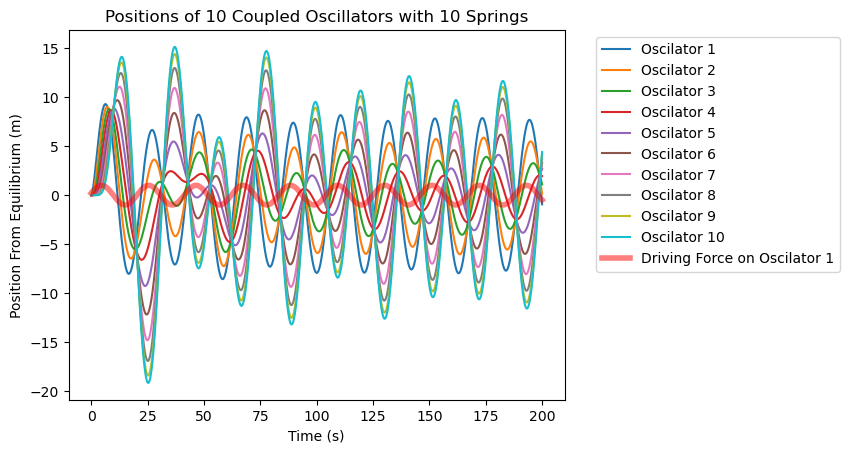

In [44]:
import matplotlib.pyplot as plt
# go through every object in the oscilator list, and plot the position of each object over time, then label them with their respective indecies
num_points = 1000
t_vals = np.linspace(0, len(oscillator_List[0].x_i)*dt, num_points) 
# The above linspace means we can get the length of the driver force running with additional calcs
for i in range(n):    
    plt.plot([i*dt for i in range(len(oscillator_List[i].x_i))],oscillator_List[i].x_i,label = 'Oscilator '+str(i+1))

for i in range(n):
    if driverParameters[i][0]!=0:
        driving_force = drivingForce[i](t_vals)
    # scale the driving force function to range of -1 to 1
        driving_force_scaled = 2*(driving_force - np.min(driving_force))/(np.max(driving_force) - np.min(driving_force)) - 1
        plt.plot(t_vals,driving_force_scaled,label = 'Driving Force on Oscilator '+str(i+1),linewidth = 4,alpha = .5,color = 'r')

# make a list of length oscilator_list[i], and set each value to the index times dt

plt.title('Positions of {n} Coupled Oscillators with {n} Springs'.format(n = n))


# plt.plot([i*dt for i in range(len(oscillator_List[0].x_i))],np.sum([oscillator_List[i].x_i for i in range(n)],axis = 0),label = 'Sum of Oscilators')
# Uncomment the above if you wanna see the total sum of the displacements

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')# multiply the labeled values on the x axis by dt to get time
plt.xlabel('Time (s)')
plt.ylabel('Position From Equilibrium (m)')

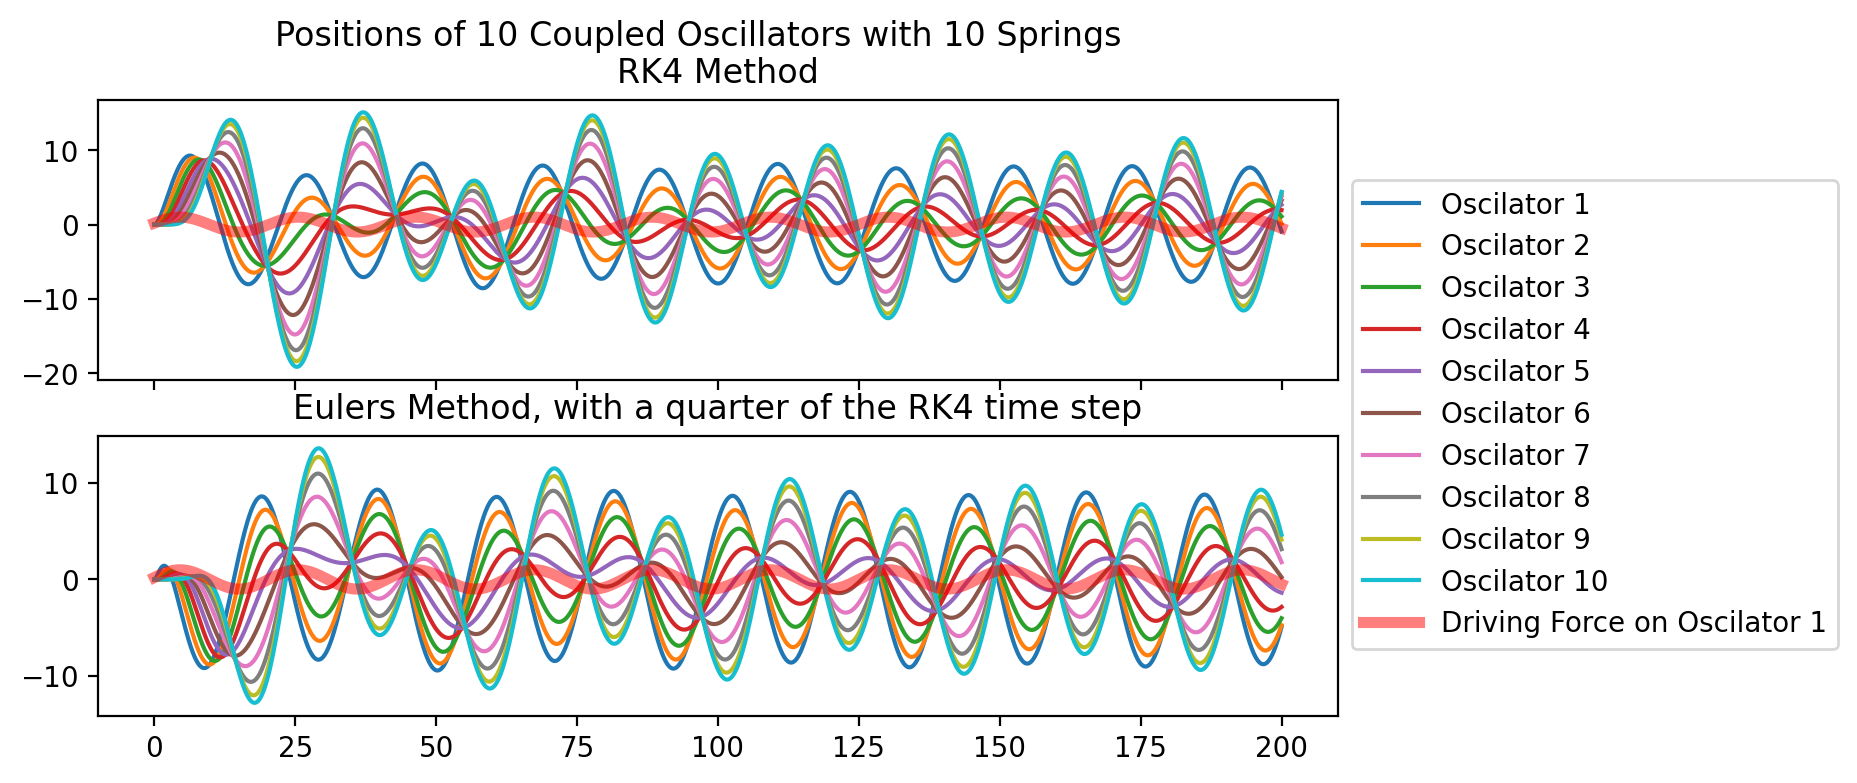

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 4), dpi=200)

for i in range(n):
    ax1.plot([i*dt for i in range(len(oscillator_List[i].x_i))],oscillator_List[i].x_i,label = 'Oscilator '+str(i+1))
    ax2.plot([t*(dt/4) for t in range(len(oscillator_List[i].x_Euler))],oscillator_List[i].x_Euler,label = 'Oscilator '+str(i+1))

# add a legend to the top subplot

# plot chart 2 on the bottom subplot
for i in range(n):
    # generate the driving force function and clip it to the range [-1, 1]
    if driverParameters[i][0]!=0:
        driving_force = drivingForce[i](t_vals)
    # scale the driving force function to range of -1 to 1
        driving_force_scaled = 2*(driving_force - np.min(driving_force))/(np.max(driving_force) - np.min(driving_force)) - 1
        
        # plot the clipped driving force function
        ax1.plot(t_vals, driving_force_scaled, label='Driving Force on Oscilator '+str(i+1), linewidth=4, alpha=.5,color = 'r')
        ax2.plot(t_vals, driving_force_scaled, label='Driving Force on Oscilator '+str(i+1), linewidth=4, alpha=.5,color = 'r')
# add a legend to the bottom subplot

# add a label to the x-axis of the bottom subplot
# ax2.set_xlabel('Time (s)')
ax1.set_title("RK4 Method")
ax2.set_title('Eulers Method, with a quarter of the RK4 time step')
# display the plot
fig.suptitle('Positions of {n} Coupled Oscillators with {n} Springs'.format(n = n))

ax1.legend(loc='center left', bbox_to_anchor=(1.0, -.125))
plt.show()

# Saving JSON

In [46]:
frames = []
for i in range(n):
    frames.append(oscillator_List[i].x_i)
# transpose frames
# rotate frames 90 degrees, because we want our input values to the array to be the frame number, not the object

frames = np.array(frames).T
# take every nth frame
frames = frames[::24]
# convert the np list to a list of lists
framesNonNPList = frames.tolist()

In [47]:
globalPositions = {'Count':n,'FrameCount':frames.shape[0],'frames'  : framesNonNPList}
print('embedded')

embedded


In [48]:
# save global positions to a json file
import json
with open('globalPositions.json', 'w') as outfile:
    json.dump(globalPositions, outfile)
